In [25]:
from matplotlib import colors, cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt


import numpy as np
import math
import numpy.ma as ma

import time
from time import process_time

import os
import utpy.utils
import utpy.vis
import flatpy

import random
from numpy import linalg as LA

import vtk
from vtk.util import numpy_support


In [2]:
def getCorrelatedEnsemble(data, numMembers):
    
    h,w = data.shape
    ensemble = np.zeros((h, w, numMembers))
    
    for i in range(numMembers):
        
        factor = np.random.uniform(0.90025,1.09975,1)
    
        ensemble[:,:,i] = factor*data
        
    return ensemble

In [5]:
foo = flatpy.nD.available_functions["ackley"]
fractional_noise_level=0.6
persistence = 0.665
n_clusters = 9
count = 50
noise_level = 0.25*persistence*fractional_noise_level
print('noise level', noise_level)
noise_model = "uniform"
ground_truth, ensemble = utpy.utils.generate_ensemble(foo, noise_level, count, noise_model)
ensemble = -ensemble
ground_truth = -ground_truth
print(ensemble.shape)
print(ensemble.max())
print(ensemble.min())
mean_realization = np.mean(ensemble, axis=2)

noise level 0.09975
xv yv 50 50
(50, 50, 50)
0.0976803883887116
-4.7743265722637975


(50, 50, 50)
write file ackley_correlated_50_50_50/ens_0.vtk
write file ackley_correlated_50_50_50/ens_1.vtk
write file ackley_correlated_50_50_50/ens_2.vtk
write file ackley_correlated_50_50_50/ens_3.vtk
write file ackley_correlated_50_50_50/ens_4.vtk
write file ackley_correlated_50_50_50/ens_5.vtk
write file ackley_correlated_50_50_50/ens_6.vtk
write file ackley_correlated_50_50_50/ens_7.vtk
write file ackley_correlated_50_50_50/ens_8.vtk
write file ackley_correlated_50_50_50/ens_9.vtk
write file ackley_correlated_50_50_50/ens_10.vtk
write file ackley_correlated_50_50_50/ens_11.vtk
write file ackley_correlated_50_50_50/ens_12.vtk
write file ackley_correlated_50_50_50/ens_13.vtk
write file ackley_correlated_50_50_50/ens_14.vtk
write file ackley_correlated_50_50_50/ens_15.vtk
write file ackley_correlated_50_50_50/ens_16.vtk
write file ackley_correlated_50_50_50/ens_17.vtk
write file ackley_correlated_50_50_50/ens_18.vtk
write file ackley_correlated_50_50_50/ens_19.vtk
write file ackley

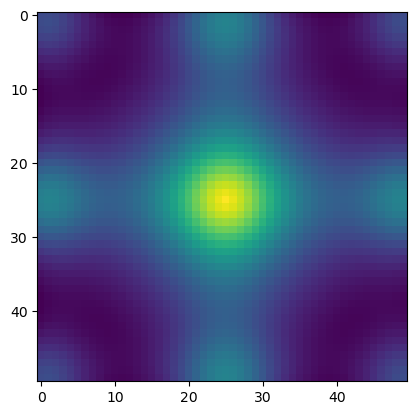

In [28]:

def writeStructuredDs(fname, ds):
    writer = vtk.vtkStructuredPointsWriter()
    writer.SetFileName(fname)
    writer.SetFileVersion(42)
    writer.SetInputData(ds)
    writer.Update()
    writer.Write() 

def writeVTKDataFromArray(xdim, ydim, zdim, file_name, inputArray):
    structured_dataset = vtk.vtkStructuredPoints()
    structured_dataset.SetDimensions(xdim, ydim, zdim)
    structured_dataset.SetOrigin(0, 0, 0)
    #print(np.array(g).shape)
    vtkArray = numpy_support.numpy_to_vtk(np.array(inputArray).flatten())
    vtkArray.SetNumberOfComponents(1)
    vtkArray.SetName("TestField")

    structured_dataset.GetPointData().AddArray(vtkArray)
    structured_dataset.GetPointData().SetActiveScalars("TestField")
    print("write file", file_name)
    writeStructuredDs(file_name,structured_dataset)


ensemble = getCorrelatedEnsemble(ground_truth, 50)

# output ensemble to vtk data set for cpp testing
# for each ensemble output a data set
# first and second index are the grid x and y
# third value is the index of ensemble element
print(ensemble.shape)
plt.imshow(ensemble[:,:,10])
vtk_data_dirname="ackley_correlated_50_50_50"

if os.path.exists(vtk_data_dirname):
    os.rmdir(vtk_data_dirname)
os.makedirs(vtk_data_dirname)

for i in range(0,50,1):
    file_name = vtk_data_dirname+"/ens"+"_"+str(i)+".vtk"
    writeVTKDataFromArray(50,50,1,file_name,ensemble[:,:,i])



In [6]:
#filename = "wind/"
#ensemble = utpy.utils.load_ensemble(filename)
#print(ensemble.shape)
#print(ensemble.max())
#print(ensemble.min())
#mean_realization = np.mean(ensemble, axis=2)

In [29]:
def adaptiveCrossingProbWithEigenDecomposition(meanArray, covMatrix, isovalue):
    
    w, v = LA.eig(covMatrix)
    
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]
    
    print('eigenvalues:',w)
    
    # Independent model if all eigenvalues are important

    if (w[3] > 0.8*w[0]):
        
        m1 = meanArray[0]
        m2 = meanArray[1]
        m3 = meanArray[2]
        m4 = meanArray[3]
        
        std1 = np.sqrt(covMatrix[0,0])
        std2 = np.sqrt(covMatrix[1,1])
        std3 = np.sqrt(covMatrix[2,2])
        std4 = np.sqrt(covMatrix[3,3])
        
        negProb1 = 0.5*(1 + math.erf((isovalue - m1)/(math.sqrt(2)*std1)))
        negProb2 = 0.5*(1 + math.erf((isovalue - m2)/(math.sqrt(2)*std2)))
        negProb3 = 0.5*(1 + math.erf((isovalue - m3)/(math.sqrt(2)*std3)))
        negProb4 = 0.5*(1 + math.erf((isovalue - m4)/(math.sqrt(2)*std4)))
        
        posProb1 = 1 - negProb1
        posProb2 = 1 - negProb2
        posProb3 = 1 - negProb3
        posProb4 = 1 - negProb4
        
        allNegativeProb = negProb1*negProb2*negProb3*negProb4
        allPositiveProb = posProb1*posProb2*posProb3*posProb4
        
        crossingProb = 1 - allNegativeProb -allPositiveProb
        
    
    # Else only use important eigenvalues for sampling
    else:
        
        indexImpEigenvalue = 0
        
        # search important eigenvalue from end. Not checked for w[3] as it would have use independent model if
        # w[3] > 0.2*w[0]
        if (w[2] > 0.2*w[0]):
            indexImpEigenvalue = 2
        
        elif (w[1] > 0.2*w[0]):
            indexImpEigenvalue = 1
            
        
        # Transformed isovalue
        transformedIso1 = (isovalue-meanArray[0]) 
        transformedIso2 = (isovalue-meanArray[1])    
        transformedIso3 = (isovalue-meanArray[2]) 
        transformedIso4 = (isovalue-meanArray[3])  
    
        numSamples = 2000
    
        if (indexImpEigenvalue == 0):
            xD = np.random.normal(0, math.sqrt(w[0]), numSamples).T
            #yD = np.random.normal(0, math.sqrt(w[1]), numSamples).T
            #zD = np.random.normal(0, math.sqrt(w[2]), numSamples).T
            #wD = np.random.normal(0, math.sqrt(w[3]), numSamples).T

            xTest = v[0][0]*xD 
            yTest = v[1][0]*xD 
            zTest = v[2][0]*xD 
            wTest = v[3][0]*xD 
            
        elif (indexImpEigenvalue == 1):
            
            xD = np.random.normal(0, math.sqrt(w[0]), numSamples).T
            yD = np.random.normal(0, math.sqrt(w[1]), numSamples).T
            #zD = np.random.normal(0, math.sqrt(w[2]), numSamples).T
            #wD = np.random.normal(0, math.sqrt(w[3]), numSamples).T

            xTest = v[0][0]*xD + v[0][1]*yD
            yTest = v[1][0]*xD + v[1][1]*yD 
            zTest = v[2][0]*xD + v[2][1]*yD
            wTest = v[3][0]*xD + v[3][1]*yD
            
        elif (indexImpEigenvalue == 2):
            
            xD = np.random.normal(0, math.sqrt(w[0]), numSamples).T
            yD = np.random.normal(0, math.sqrt(w[1]), numSamples).T
            zD = np.random.normal(0, math.sqrt(w[2]), numSamples).T
            #wD = np.random.normal(0, math.sqrt(w[3]), numSamples).T

            xTest = v[0][0]*xD + v[0][1]*yD + v[0][2]*zD 
            yTest = v[1][0]*xD + v[1][1]*yD + v[1][2]*zD 
            zTest = v[2][0]*xD + v[2][1]*yD + v[2][2]*zD
            wTest = v[3][0]*xD + v[3][1]*yD + v[3][2]*zD

        numNegativeNonCrossing = 0
        for i in range(numSamples):
            if ((xTest[i]<=transformedIso1) and (yTest[i]<=transformedIso2) and (zTest[i]<=transformedIso3) and (wTest[i]<=transformedIso4)):
                numNegativeNonCrossing = numNegativeNonCrossing + 1
        
        numPositiveNonCrossing = 0
        for i in range(numSamples):
            if ((xTest[i]>=transformedIso1) and (yTest[i]>=transformedIso2) and (zTest[i]>=transformedIso3) and (wTest[i]>=transformedIso4)):
                numPositiveNonCrossing = numPositiveNonCrossing + 1
    
        crossingProb = 1.0 - (numNegativeNonCrossing/numSamples) - (numPositiveNonCrossing/numSamples)
    
    return crossingProb, w

In [30]:
def getCrossingProbWithEigenDecomposition(meanArray, covMatrix, isovalue):
    
    w, v = LA.eig(covMatrix)
    
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]
    
    #print('eigenvalues:',w)

    # Transformed isovalue
    transformedIso1 = (isovalue-meanArray[0]) 
    transformedIso2 = (isovalue-meanArray[1])    
    transformedIso3 = (isovalue-meanArray[2]) 
    transformedIso4 = (isovalue-meanArray[3])  
    
    numSamples = 2000
    
    xD = np.random.normal(0, math.sqrt(w[0]), numSamples).T
    #yD = np.random.normal(0, math.sqrt(w[1]), numSamples).T
    #zD = np.random.normal(0, math.sqrt(w[2]), numSamples).T
    #wD = np.random.normal(0, math.sqrt(w[3]), numSamples).T

    xTest = v[0][0]*xD 
    yTest = v[1][0]*xD 
    zTest = v[2][0]*xD 
    wTest = v[3][0]*xD 

    numNegativeNonCrossing = 0
    for i in range(numSamples):
        if ((xTest[i]<=transformedIso1) and (yTest[i]<=transformedIso2) and (zTest[i]<=transformedIso3) and (wTest[i]<=transformedIso4)):
            numNegativeNonCrossing = numNegativeNonCrossing + 1
        
    numPositiveNonCrossing = 0
    for i in range(numSamples):
        if ((xTest[i]>=transformedIso1) and (yTest[i]>=transformedIso2) and (zTest[i]>=transformedIso3) and (wTest[i]>=transformedIso4)):
            numPositiveNonCrossing = numPositiveNonCrossing + 1
    
    #q1 = (v[0][0]**2)*abs(w[0]) + (v[0][1]**2)*abs(w[1]) + (v[0][2]**2)*abs(w[2]) + (v[0][3]**2)*abs(w[3])
    #std1 = math.sqrt(q1)

    #q2 = (v[1][0]**2)*abs(w[0]) + (v[1][1]**2)*abs(w[1]) + (v[1][2]**2)*abs(w[2]) + (v[1][3]**2)*abs(w[3])
    #std2 = math.sqrt(q2)
    
    #q3 = (v[2][0]**2)*abs(w[0]) + (v[2][1]**2)*abs(w[1]) + (v[2][2]**2)*abs(w[2]) + (v[2][3]**2)*abs(w[3])
    #std3 = math.sqrt(q3)
    
    #q4 = (v[3][0]**2)*abs(w[0]) + (v[3][1]**2)*abs(w[1]) + (v[3][2]**2)*abs(w[2]) + (v[3][3]**2)*abs(w[3])
    #std4 = math.sqrt(q4)
    
    #negativeProbm1 = 0.5*(1 + math.erf((transformedIso1 - 0)/(math.sqrt(2)*std1)))
    #negativeProbm2 = 0.5*(1 + math.erf((transformedIso2 - 0)/(math.sqrt(2)*std2)))
    #negativeProbm3 = 0.5*(1 + math.erf((transformedIso3 - 0)/(math.sqrt(2)*std3)))
    #negativeProbm4 = 0.5*(1 + math.erf((transformedIso4 - 0)/(math.sqrt(2)*std4)))
    
    #positiveProbm1 = 1.0 - negativeProbm1
    #positiveProbm2 = 1.0 - negativeProbm2
    #positiveProbm3 = 1.0 - negativeProbm3
    #positiveProbm4 = 1.0 - negativeProbm4
    
    #negativeNonCrossingProb = negativeProbm1*negativeProbm2*negativeProbm3*negativeProbm4
    #positiveNonCrossingProb = positiveProbm1*positiveProbm2*positiveProbm3*positiveProbm4
    
    crossingProb = 1.0 - (numNegativeNonCrossing/numSamples) - (numPositiveNonCrossing/numSamples)
    
    return crossingProb, w

In [31]:
def closedFormWithEigenDecompositionProbabilisticMarchingSquaresMultivariate(ensemble, isovalue):
    
    h, w, d = ensemble.shape
    minimumGrid = np.zeros((h,w))
    maximumGrid = np.zeros((h,w))
    eigenmap = np.zeros((h,w,4))
    
    for i in range(h):
        for j in range(w):
            minimum = math.inf
            maximum = -math.inf
            for k in range(d):
                if(ensemble[i,j,k] < minimum):
                    minimum = ensemble[i,j,k]
                if(ensemble[i,j,k] > maximum):
                    maximum = ensemble[i,j,k]    
            minimumGrid[i,j] = minimum
            maximumGrid[i,j] = maximum
            
    random.seed(10)        
            
    # Use eigenvalue approach

    crossingProbabilities = np.zeros((h-1,w-1))
    for i in range(h-1):
        for j in range(w-1):    
            x1min = minimumGrid[i,j]
            x1max = maximumGrid[i,j]
            x2min = minimumGrid[i+1,j]
            x2max = maximumGrid[i+1,j]
            x3min = minimumGrid[i+1,j+1]
            x3max = maximumGrid[i+1,j+1]
            x4min = minimumGrid[i,j+1]
            x4max = maximumGrid[i,j+1]
            
            minCell = min(x1min, x2min, x3min, x4min)
            maxCell = max(x1max, x2max, x3max, x4max)
            
            # sample if isovalue falls between minCell and maxCell
            if (isovalue > minCell) and (isovalue < maxCell):
                
                 #Estimate mean and covariance matrices from samples
                m1 = np.mean(ensemble[i,j,:])
                m2 = np.mean(ensemble[i+1,j,:])   
                m3 = np.mean(ensemble[i+1,j+1,:])
                m4 = np.mean(ensemble[i,j+1,:])     
                    
                meanArray = np.array([m1,m2,m3,m4])     
                #print(meanArray)
                
                d1 = ensemble[i,j,:]
                d2 = ensemble[i+1,j,:]
                d3 = ensemble[i+1,j+1,:]
                d4 = ensemble[i,j+1,:]
                
                observedData = np.array([d1,d2,d3,d4])   
                
                covMatrix = np.cov(observedData)
                
                #crossingProbEig, eigvals = getCrossingProbWithEigenDecomposition(meanArray, covMatrix, isovalue)
                crossingProbEig, eigvals = adaptiveCrossingProbWithEigenDecomposition(meanArray, covMatrix, isovalue)
                
               # print(meanArray)
               # print(covMatrix)
                
                # Draw samples from multivariate normal
                #samples = np.random.multivariate_normal(meanArray, covMatrix, numSamples)
                                
                #x1Samples = samples[:,0]
                #x2Samples = samples[:,1]
                #x3Samples = samples[:,2]
                #x4Samples = samples[:,3]
                
                #x1Samples = x1Samples.reshape(1, numSamples)
                #x2Samples = x2Samples.reshape(1, numSamples)
                #x3Samples = x3Samples.reshape(1, numSamples)
                #x4Samples = x4Samples.reshape(1, numSamples)
                #x1Samples = np.random.uniform(low=x1min, high=x1max, size=(1,numSamples))
                ##x2Samples = np.random.uniform(low=x2min, high=x2max, size=(1,numSamples))
                ##x3Samples = np.random.uniform(low=x3min, high=x3max, size=(1,numSamples))
                ##x4Samples = np.random.uniform(low=x4min, high=x4max, size=(1,numSamples))
                
                #crossings = 0
                
                #for k in range(numSamples):
                #    minVal = min(x1Samples[0,k],x2Samples[0,k],x3Samples[0,k],x4Samples[0,k])
                #    maxVal = max(x1Samples[0,k],x2Samples[0,k],x3Samples[0,k],x4Samples[0,k])
                #    if (isovalue > minVal) and (isovalue < maxVal):
                #        crossings = crossings + 1;
                        
                #crossingProb = crossings/numSamples
                
                #print('crossing Prob True', crossingProb, 'crossing Prob Eig', crossingProbEig)
                
                crossingProbabilities[i,j] = crossingProbEig
                eigenmap[i,j,:] = eigvals
                
    return crossingProbabilities, eigenmap

In [32]:
def probabilisticMarchingSquaresMultivariate(ensemble, isovalue):
    
    h, w, d = ensemble.shape
    minimumGrid = np.zeros((h,w))
    maximumGrid = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            minimum = math.inf
            maximum = -math.inf
            for k in range(d):
                if(ensemble[i,j,k] < minimum):
                    minimum = ensemble[i,j,k]
                if(ensemble[i,j,k] > maximum):
                    maximum = ensemble[i,j,k]    
            minimumGrid[i,j] = minimum
            maximumGrid[i,j] = maximum
            
    random.seed(10)        
            
    # perform sampling
    numSamples = 2000
    crossingProbabilities = np.zeros((h-1,w-1))
    for i in range(h-1):
        for j in range(w-1):    
            x1min = minimumGrid[i,j]
            x1max = maximumGrid[i,j]
            x2min = minimumGrid[i+1,j]
            x2max = maximumGrid[i+1,j]
            x3min = minimumGrid[i+1,j+1]
            x3max = maximumGrid[i+1,j+1]
            x4min = minimumGrid[i,j+1]
            x4max = maximumGrid[i,j+1]
            
            minCell = min(x1min, x2min, x3min, x4min)
            maxCell = max(x1max, x2max, x3max, x4max)
            
            # sample if isovalue falls between minCell and maxCell
            if (isovalue > minCell) and (isovalue < maxCell):
                
                 #Estimate mean and covariance matrices from samples
                m1 = np.mean(ensemble[i,j,:])
                m2 = np.mean(ensemble[i+1,j,:])   
                m3 = np.mean(ensemble[i+1,j+1,:])
                m4 = np.mean(ensemble[i,j+1,:])     
                    
                meanArray = np.array([m1,m2,m3,m4])     
                #print(meanArray)
                
                d1 = ensemble[i,j,:]
                d2 = ensemble[i+1,j,:]
                d3 = ensemble[i+1,j+1,:]
                d4 = ensemble[i,j+1,:]
                
                observedData = np.array([d1,d2,d3,d4])   
                
                covMatrix = np.cov(observedData)
                
                # Draw samples from multivariate normal
                samples = np.random.multivariate_normal(meanArray, covMatrix, numSamples)
                                
                x1Samples = samples[:,0]
                x2Samples = samples[:,1]
                x3Samples = samples[:,2]
                x4Samples = samples[:,3]
                
                x1Samples = x1Samples.reshape(1, numSamples)
                x2Samples = x2Samples.reshape(1, numSamples)
                x3Samples = x3Samples.reshape(1, numSamples)
                x4Samples = x4Samples.reshape(1, numSamples)
                #x1Samples = np.random.uniform(low=x1min, high=x1max, size=(1,numSamples))
                #x2Samples = np.random.uniform(low=x2min, high=x2max, size=(1,numSamples))
                #x3Samples = np.random.uniform(low=x3min, high=x3max, size=(1,numSamples))
                #x4Samples = np.random.uniform(low=x4min, high=x4max, size=(1,numSamples))
                
                crossings = 0
                
                for k in range(numSamples):
                    minVal = min(x1Samples[0,k],x2Samples[0,k],x3Samples[0,k],x4Samples[0,k])
                    maxVal = max(x1Samples[0,k],x2Samples[0,k],x3Samples[0,k],x4Samples[0,k])
                    if (isovalue > minVal) and (isovalue < maxVal):
                        crossings = crossings + 1;
                        
                crossingProb = crossings/numSamples
                
                crossingProbabilities[i,j] = crossingProb
                
    return crossingProbabilities

eigenvalues: [ 1.73505962e-01  0.00000000e+00  0.00000000e+00 -1.09745201e-17]
eigenvalues: [ 1.75028420e-01  1.39049841e-17  0.00000000e+00 -7.98714637e-18]
eigenvalues: [ 1.70469644e-01  3.43994454e-19  0.00000000e+00 -1.10903299e-17]
eigenvalues: [ 1.47913041e-01 -1.37651125e-19 -7.82845513e-18 -2.77555756e-17]
eigenvalues: [ 1.27418043e-01  2.06693992e-18  0.00000000e+00 -9.67868967e-18]
eigenvalues: [ 1.10596428e-01  9.08592141e-18  0.00000000e+00 -1.20033163e-17]
eigenvalues: [ 1.10596428e-01  2.77555756e-17  3.42814708e-18 -3.63028890e-18]
eigenvalues: [ 1.27418043e-01  0.00000000e+00 -3.62217169e-18 -7.96074781e-18]
eigenvalues: [ 1.47913041e-01  0.00000000e+00 -6.80297243e-18 -8.47273897e-18]
eigenvalues: [ 1.70469644e-01  0.00000000e+00 -3.18464565e-18 -6.93990158e-18]
eigenvalues: [ 1.75028420e-01  5.55111512e-17 -7.07201004e-20 -1.24191450e-17]
eigenvalues: [ 1.75028420e-01  1.55228514e-17  0.00000000e+00 -9.08300408e-18]
eigenvalues: [ 1.76156272e-01  6.01853108e-36  0.000

/var/folders/zh/rqpzj7q172g009fq5wyn44n5y32yvy/T/ipykernel_33580/896909298.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  xD = np.random.normal(0, math.sqrt(w[0]), numSamples).T
/var/folders/zh/rqpzj7q172g009fq5wyn44n5y32yvy/T/ipykernel_33580/75740001.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenmap[i,j,:] = eigvals


eigenvalues: [1.57462276e-01 7.78174839e-18 2.78322898e-19 0.00000000e+00]
eigenvalues: [ 1.46018245e-01  1.05905627e-17 -1.08417519e-17 -2.77555756e-17]
eigenvalues: [1.35692085e-01 6.76430542e-18 4.52189810e-19 0.00000000e+00]
eigenvalues: [ 1.27159648e-01  1.38777878e-17  7.92048519e-18 -3.31523949e-18]
eigenvalues: [ 1.21056077e-01  1.02121216e-17  3.95088095e-18 -1.38777878e-17]
eigenvalues: [ 1.17871535e-01  9.72929106e-20  0.00000000e+00 -1.01777139e-18]
eigenvalues: [1.17871535e-01+0.00000000e+00j 1.38777878e-17+0.00000000e+00j
 4.97394559e-18+1.21318795e-18j 4.97394559e-18-1.21318795e-18j]
eigenvalues: [ 1.21056077e-01  4.99960034e-18  0.00000000e+00 -1.06420416e-17]
eigenvalues: [1.27159648e-01 4.13154348e-18 3.14643651e-18 0.00000000e+00]
eigenvalues: [ 1.35692085e-01  3.70607171e-18  0.00000000e+00 -1.38694188e-17]
eigenvalues: [ 1.46018245e-01  4.12756361e-18  0.00000000e+00 -6.73774284e-18]
eigenvalues: [ 1.57462276e-01  8.38150430e-18  1.09231430e-19 -1.38777878e-17]
eig

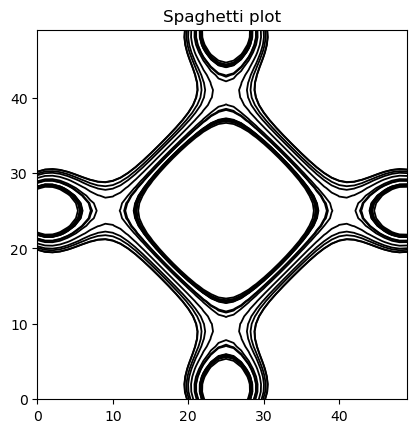

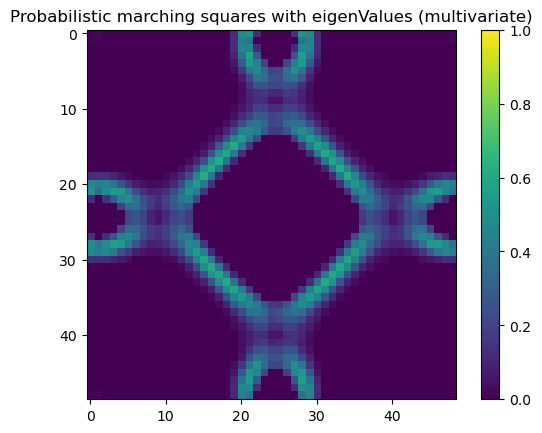

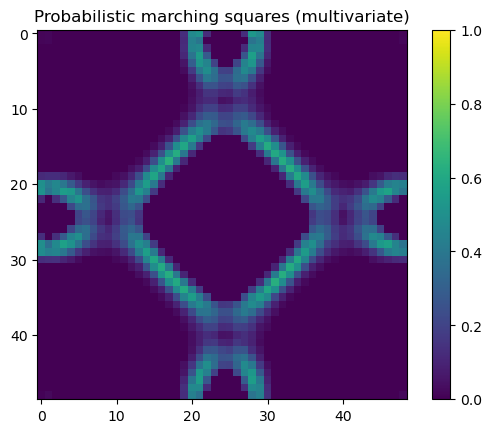

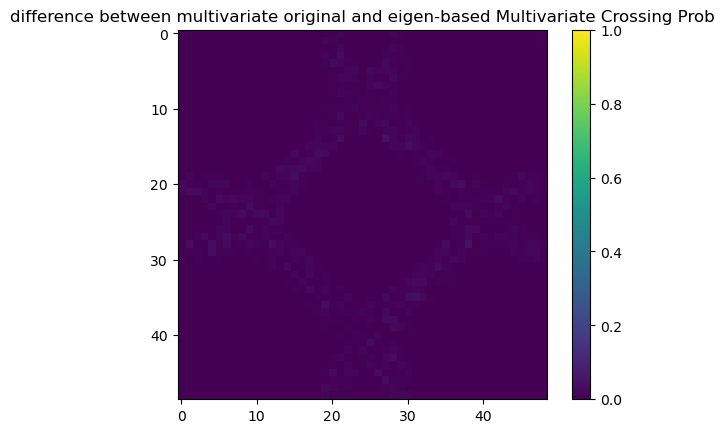

In [33]:
isovalue = -3.25

plt.figure()
plt.title('Spaghetti plot')
h, w, d = ensemble.shape
for k in range(15):
    plt.contour(ensemble[:,:,k], levels=[isovalue], colors="#000000", linewidths=[1.3], linestyles=['solid']) 
plt.axis('scaled')

# Visualize crossing probabilities : Probabilistic marching squares (closed-form with eigenValue)
t1_start = process_time() 
eigCrossingProbabilitiesMultivariate, eigenmap = closedFormWithEigenDecompositionProbabilisticMarchingSquaresMultivariate(ensemble, isovalue)
t1_stop = process_time()
print('Eigenvalue-based multivariate time:', t1_stop-t1_start)
plt.figure()
plt.title('Probabilistic marching squares with eigenValues (multivariate)')
img2 = plt.imshow(eigCrossingProbabilitiesMultivariate, vmin=0,vmax=1)
#plt.gca().invert_yaxis()
plt.colorbar(img2)
plt.gcf().set_dpi(100)

# Visualize crossing probabilities : Probabilistic marching squares
t1_start = process_time() 
crossingProbabilitiesMultivariate = probabilisticMarchingSquaresMultivariate(ensemble, isovalue)
t1_stop = process_time()
print('multivariate time:', t1_stop-t1_start)
plt.figure()
plt.title('Probabilistic marching squares (multivariate)')
img2 = plt.imshow(crossingProbabilitiesMultivariate, vmin=0,vmax=1)
#plt.gca().invert_yaxis()
plt.colorbar(img2)
plt.gcf().set_dpi(100)

# Visualize difference between multivariate and eigen-based crossing probabilities 
plt.figure()
plt.title('difference between multivariate original and eigen-based Multivariate Crossing Prob')
img2 = plt.imshow(abs(eigCrossingProbabilitiesMultivariate-crossingProbabilitiesMultivariate), vmin=0,vmax=1)
#plt.gca().invert_yaxis()
plt.colorbar(img2)
plt.gcf().set_dpi(100)

0.003167159168779283


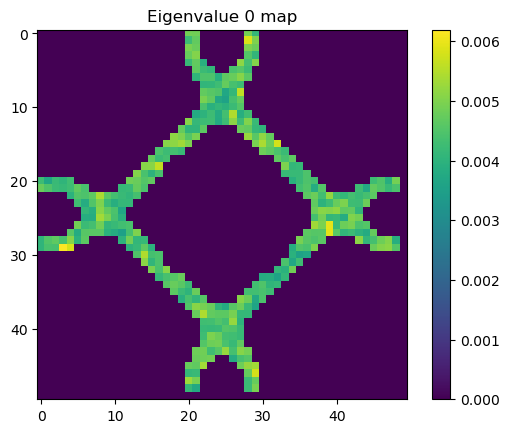

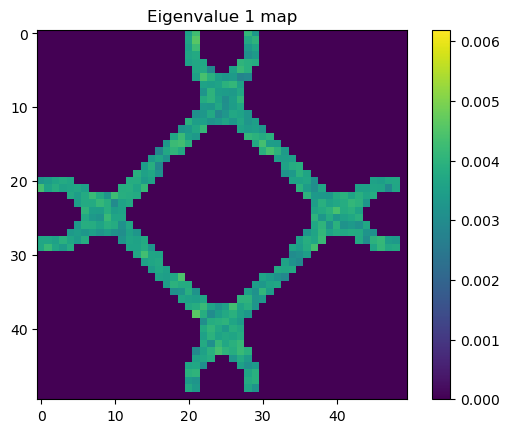

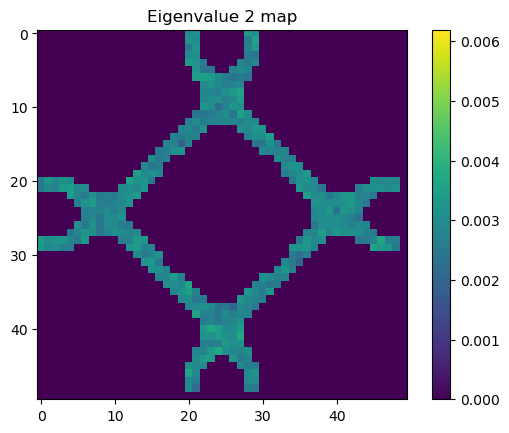

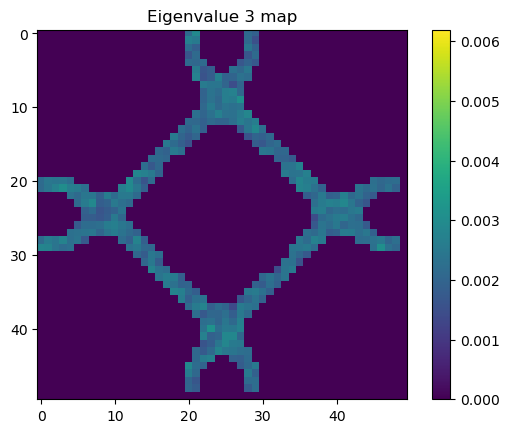

In [13]:
maxEigenVal = np.amax(eigenmap)

print(np.amax(eigenmap[:,:,3]))

plt.figure()
plt.title('Eigenvalue 0 map')
img2 = plt.imshow(eigenmap[:,:,0], vmin=0, vmax=maxEigenVal)
#plt.gca().invert_yaxis()
plt.colorbar(img2)
plt.gcf().set_dpi(100)

plt.figure()
plt.title('Eigenvalue 1 map')
img2 = plt.imshow(eigenmap[:,:,1], vmin=0, vmax=maxEigenVal)
#plt.gca().invert_yaxis()
plt.colorbar(img2)
plt.gcf().set_dpi(100)

plt.figure()
plt.title('Eigenvalue 2 map')
img2 = plt.imshow(eigenmap[:,:,2], vmin=0, vmax=maxEigenVal)
#plt.gca().invert_yaxis()
plt.colorbar(img2)
plt.gcf().set_dpi(100)

plt.figure()
plt.title('Eigenvalue 3 map')
img2 = plt.imshow(eigenmap[:,:,3], vmin=0, vmax=maxEigenVal)
#plt.gca().invert_yaxis()
plt.colorbar(img2)
plt.gcf().set_dpi(100)